# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:


In [1]:
import pandas as pd
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *

from autoemulate.experimental.simulations.projectile import Projectile

import warnings
warnings.filterwarnings("ignore")

## Toy simulation

Before we build an emulator with AutoEmulate, we need to get a set of input/output pairs from our simulation to use as training data.

Below is a toy simulation for a projectile's motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). The simulation includes:
- Inputs: drag coefficient (log scale), velocity
- Outputs: distance the projectile travelled


In [2]:
projectile = Projectile()

# sample from a simulation
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 1.20ksample/s]


(torch.Size([500, 2]), torch.Size([500, 1]))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and hyperparameter optimisation in just a few lines of code. First, let's check the names of the available emulator models.


In [3]:
# Print list of available emulators
AutoEmulate.list_emulators()

,Emulator
0,GaussianProcessExact
1,GaussianProcessExactCorrelated
2,LightGBM
3,SupportVectorMachine
4,RadialBasisFunctions
5,RandomForest
6,MLP
7,EnsembleMLP
8,EnsembleMLPDropout


Now let's initialise an `AutoEmulate` object.

This provides the simulation inputs and outputs, then fits a range of different models to the data, evaluating on witheld test data.

In [4]:
ae = AutoEmulate(x, y)

Comparing models: 100%|██████████| 9.00/9.00 [04:09<00:00, 27.8s/model]


Look at the summary for a comparison of emulator performace.

In [ ]:
ae.summarise()

,model_name,x_transforms,y_transforms,config,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
4,RadialBasisFunctions,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'gaussian', 'degree': 2, 'smoothing...",15.100912,0.999251,0.000348,0.999354,0.000112
1,GaussianProcessExactCorrelated,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function zero_mean at 0x30...,35.860809,0.975162,0.010130,0.965217,0.005827
2,LightGBM,[StandardizeTransform()],[StandardizeTransform()],"{'num_leaves': 89, 'max_depth': 2, 'learning_r...",39.194981,0.967744,0.011130,0.942547,0.009963
0,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function zero_mean at 0x30...,39.603783,0.963526,0.011194,0.953418,0.006309
6,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 50, 'layer_dims': [64, 32, 16], 'lr...",42.412567,0.957706,0.004417,0.945325,0.008483
3,SupportVectorMachine,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'poly', 'degree': 3, 'gamma': 'auto...",44.884586,0.941765,0.016257,0.945404,0.004572
5,RandomForest,[StandardizeTransform()],[StandardizeTransform()],"{'n_estimators': 268, 'min_samples_split': 14,...",51.849110,0.893143,0.052685,0.944426,0.011358
8,EnsembleMLPDropout,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 8, 'epochs': 100, 'layer_dims'...",56.129391,0.867089,0.019270,0.862260,0.014564
7,EnsembleMLP,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 6, 'epochs': 50, 'layer_dims':...",67.022606,0.720671,0.007743,0.712737,0.006100


Choose an emulator based on the index from the summary dataframe, or quickly get the best result (based on `r2_score`).

In [6]:
best = ae.best_result()
print("Model with id: ", best.id, " performed best: ", best.model_name)

Model with id:  4  performed best:  RadialBasisFunctions


Let's take a look at the configuration of the best model. These are the values of the model's hyperparameters.

In [7]:
best.config

{'kernel': 'gaussian', 'degree': 2, 'smoothing': 0.055212542058606706}

Plot the emulator predictions against the simulator outputs.

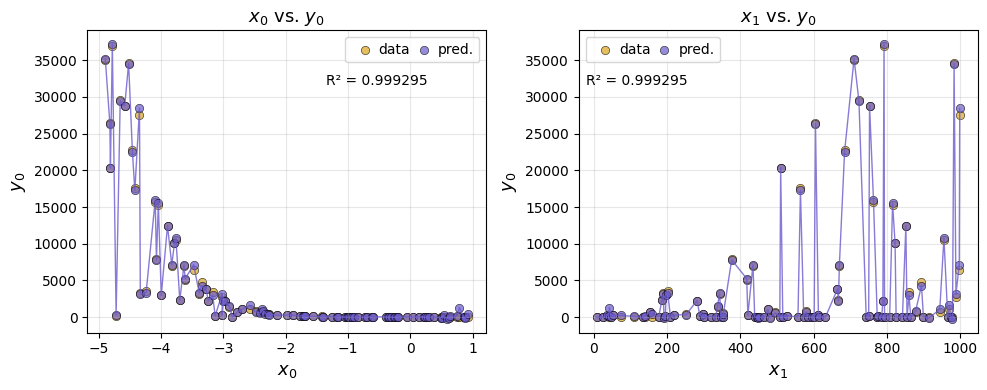

In [8]:
ae.plot(best)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [9]:
best.model.predict(x[:10])

tensor([[ 5.6852e+03],
        [ 1.6878e+01],
        [ 1.0413e+01],
        [ 2.5501e+02],
        [-4.5424e+01],
        [ 6.3762e+03],
        [ 6.0650e+02],
        [ 2.9446e+04],
        [ 4.1558e+03],
        [ 1.3868e+01]])

# Saving and loading emulators

Emulators can be saved to disk and loaded again later.

In [10]:
# Make a directory to save Emulator models
import os
path = "my_emulators"
if not os.path.exists(path):
    os.makedirs(path)

Save the best result, best performing emulator plus metadata, to disk.

In [11]:
# The use_timestamp paramater ensures a new result is saved each time the save method is called
best_result_filepath = ae.save(best, path, use_timestamp=True)
print("Model and metadata saved to: ", best_result_filepath)

Model and metadata saved to:  my_emulators/RadialBasisFunctions_4_20250716_144908


In [ ]:
loaded_result = ae.load(best_result_filepath)

In [ ]:
loaded_result.config

{'kernel': 'gaussian', 'degree': 2, 'smoothing': 0.055212542058606706}

In [ ]:
loaded_result.model.predict(x[:10])

tensor([[ 5.6852e+03],
        [ 1.6878e+01],
        [ 1.0413e+01],
        [ 2.5501e+02],
        [-4.5424e+01],
        [ 6.3762e+03],
        [ 6.0650e+02],
        [ 2.9446e+04],
        [ 4.1558e+03],
        [ 1.3868e+01]])